<a href="https://colab.research.google.com/github/DavidToth1/PRA3024/blob/main/PRA3024_ML_Assignment_3_David_Toth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

from tensorflow import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


In [ ]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


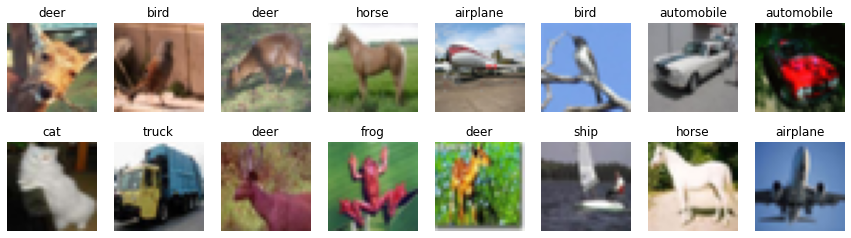

In [ ]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()
    
    # Building my convolutional neural network
    
    # Starting with 32 filters, setting the kernel dimensions as 3x3, the activation function LeakyReLU,
    # and adding padding of zeros to preserve the spatial dimentions. Layers are added 2 at a time for each amount of filters.
    model.add(Conv2D(32, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(Conv2D(32, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    # Adding a batch normalization after every double layer and pooling layer in order to rescale and recenter the data iputs,
    # and make my neural network more stable
    model.add(BatchNormalization())
    # Adding the MaxPooling2D after every double layer to retrieve the maximum value in each patch of the feature map
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    
    # Filter size of every double layers increases by a factor of 2
    model.add(Conv2D(64, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(Conv2D(64, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization()) 
    
    model.add(Conv2D(128, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(Conv2D(128, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(Conv2D(256, kernel_size = (3,3), activation="LeakyReLU", padding="SAME"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    # Flattening the feature map achieved above into a single column (array)
    # to transfer the data into a neural network
    model.add(Flatten())
    # Connecting all of the neurons from all the layers with Dense 
    # (Setting the argument as 10 for the number of classes)
    model.add(Dense(10))
    # Dropout value is optimal between 0 - 0.5
    model.add(Dropout(0.25))
    # Batch normalization one final time
    model.add(BatchNormalization())
    model.add(Activation("softmax")) 

    return model

In [ ]:
INIT_LR = 5e-3  # initial learning rate
# Keeping the batch size at 32 since it provides the 
# least error rate
BATCH_SIZE = 32
# Setting the epoch number at 15 to not over-iterate through the data
EPOCHS = 15


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD., replacing lr with learning_rate (lr has depricated)
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/15
1250/1250 [==============================] - 31s 10ms/step - loss: 1.6111 - accuracy: 0.4329 - val_loss: 1.2214 - val_accuracy: 0.5757
Epoch 2/15
1250/1250 [==============================] - 12s 10ms/step - loss: 1.2353 - accuracy: 0.5725 - val_loss: 0.8714 - val_accuracy: 0.7095
Epoch 3/15
1250/1250 [==============================] - 13s 11ms/step - loss: 1.0885 - accuracy: 0.6154 - val_loss: 0.7702 - val_accuracy: 0.7472
Epoch 4/15
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9864 - accuracy: 0.6518 - val_loss: 0.7407 - val_accuracy: 0.7498
Epoch 5/15
1250/1250 [==============================] - 12s 10ms/step - loss: 0.8899 - accuracy: 0.6826 - val_loss: 0.6350 - val_accuracy: 0.7927
Epoch 6/15
1250/1250 [==============================] - 13s 11ms/step - loss: 0.8358 - accuracy: 0.6991 - val_loss: 0.7517 - val_accuracy: 0.7478
Epoch 7/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7777 - accuracy: 0.7169 - val_loss: 0.7212 -

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

Epoch 1/15
1125/1125 [==============================] - 11s 10ms/step - loss: 0.3217 - accuracy: 0.8687 - val_loss: 0.2252 - val_accuracy: 0.9300
Epoch 2/15
1125/1125 [==============================] - 10s 9ms/step - loss: 0.3203 - accuracy: 0.8718 - val_loss: 0.2310 - val_accuracy: 0.9268
Epoch 3/15
1125/1125 [==============================] - 10s 9ms/step - loss: 0.3192 - accuracy: 0.8695 - val_loss: 0.2448 - val_accuracy: 0.9195
Epoch 4/15
1125/1125 [==============================] - 10s 9ms/step - loss: 0.3180 - accuracy: 0.8698 - val_loss: 0.2260 - val_accuracy: 0.9275
Epoch 5/15
1125/1125 [==============================] - 10s 9ms/step - loss: 0.3124 - accuracy: 0.8717 - val_loss: 0.2320 - val_accuracy: 0.9222
Epoch 6/15
1125/1125 [==============================] - 11s 9ms/step - loss: 0.3223 - accuracy: 0.8688 - val_loss: 0.2393 - val_accuracy: 0.9252
Epoch 7/15
1125/1125 [==============================] - 10s 9ms/step - loss: 0.3129 - accuracy: 0.8734 - val_loss: 0.2318 - val_a

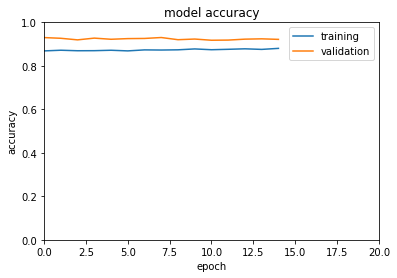

In [ ]:
# Plotting the accuracy of the model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=.1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.xlim(0,20)
plt.ylim(0,1)
plt.show()

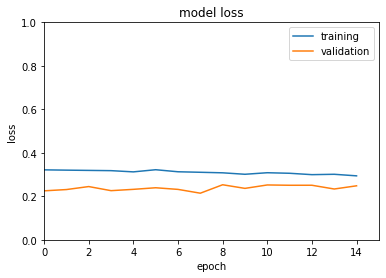

In [ ]:
# Plotting the loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.xlim(0,15)
plt.ylim(0,1)
plt.show()

313/313 [==============================] - 1s 3ms/step


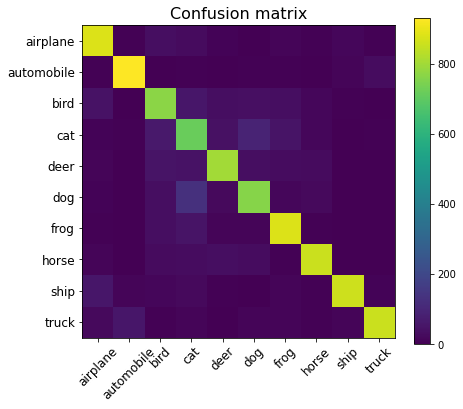

Test accuracy: 0.8311


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

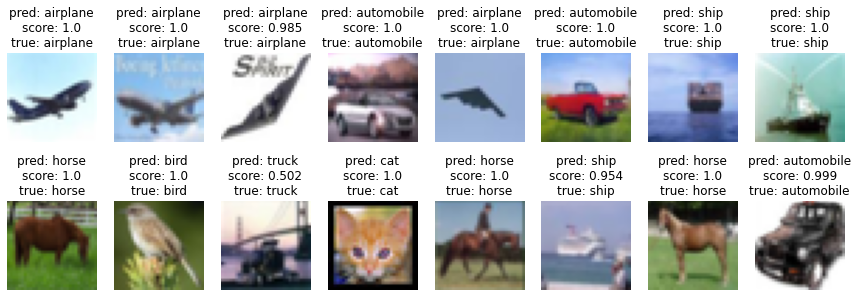

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# **CNN Report**

**My goal was to make a convolutional neural network that is quick and simple yet effective. A network that can compile under 5 minutes, not require a large number of epochs yet still reach a high value of accuracy.**

I began by writing a convolutional layer using Conv2D. I started with 32 filters (this number seemed pretty popular online), and set the kernel dimensions as 3x3 (same reason as the filters). For the activation function I used the "LeakyReLU" (since it was already imported for me), and I set the padding as "SAME" to preserve the spatial dimensions (I also tried to set the padding to its alternative - "VALID", however the results were worse).

Underneath the convolutional layer I added a layer of MaxPooling2D to get the highest value of each part of the feature map and improve the output. 

I then started building more convolutional layers in the same way, with the only change being the doubling of the amount of filters (thanks to google). I went through 4 intervals of the filters, with the filter amount of the final layer being 256 (I also tried going up to 512 however the results were not significantly better, yet did cost more time).

I then added a Flatten layer to turn the feature map into a single column array, so that the data can enter a neural network.  

I then added a Dense layer to connect all the neurons from all the layers written, I made the argument in the Dense layer equal the amount of classes.

Then I added a Dropout layer to help avoid overfitting (I read that it is optimal between 0 - 0.5 so I played with the values until I found the one giving the best results)

Finally I added a BatchNormalization to rescale and recenter the data inputs.

At the next code block I kept the batch size at 32 (I read that this value provides the least error rate), and set the number of epochs to 15 (to fit within my goal of making a fast neural network). 

After running my code I was happy yet not satisfied.

So upon my research to find the best solutions to improve my code, I saw that the value of accuracy can increase by adding another layer underneath an existing layer, creating "double layers", after doubling each layer I noticed an immediate increase in the value of accuarcy, however the trend in which it was increasing was unstable, sharply going up and down. So upon more research I found that I can help stabilize my neural network by adding batch normalizations underneath each convolutional layer (the double ones in my case), and underneath each MaxPooling2D layer. After implementing these I managed to reach a stable increase in the values of accuarcy.

At that point I have already managed to build a neural network which was strong and efficient, however my greedy nature kicked in. I wanted to create an even better network, so I added another convolutional layer under each double layer (to make a triple layer). The results did not end up as an improvement, in fact all that did was increase the time it took the network to compile, so I went back to my double layers.
Then I tried to alter the value of the dropout from very small to very large, however that resulted in heavy instabilities in the values of accuarcy.

And so, I remained with this existing structure of my CNN. I have also managed to reach my initial goal - my neural network compiles under 5 minutes (~3.5 minutes), and it is very stable around the accuracy values between 81.5%-83.5% as final values of accuracy.

The plots of the model accuracy and loss also show a clear and stable progression without overfitting.

Some resources that I found helpful:

https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83


# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


